<!--BOOK_INFORMATION-->
<a href="https://www.packtpub.com/big-data-and-business-intelligence/machine-learning-opencv" target="_blank"><img align="left" src="data/cover.jpg" style="width: 76px; height: 100px; background: white; padding: 1px; border: 1px solid black; margin-right:10px;"></a>
*This notebook contains an excerpt from the book [Machine Learning for OpenCV 2nd Edition](https://www.packtpub.com/big-data-and-business-intelligence/machine-learning-opencv) by Vishwesh Ravi Shrimali.
The code is released under the [MIT license](https://opensource.org/licenses/MIT),
and is available on [GitHub](https://github.com/vishwesh5/OpenCV-ML).*

*Note that this excerpt contains only the raw code - the book is rich with additional explanations and illustrations.
If you find this content useful, please consider supporting the work by
[buying the book](https://www.packtpub.com/big-data-and-business-intelligence/machine-learning-opencv)!*

<!--NAVIGATION-->
< [Applying Lasso and Ridge Regression](03.04-Applying-Lasso-and-Ridge-Regression.ipynb) | [Contents](../README.md) | [Representing Data and Engineering Features](04.00-Representing-Data-and-Engineering-Features.ipynb) >

# Classifying Iris Species Using Logistic Regression

Another famous dataset in the world of machine learning is called the **Iris dataset**.

The Iris
dataset contains measurements of 150 iris flowers from three different species: setosa,
versicolor, and viriginica. These measurements include the length and width of the petals,
and the length and width of the sepals, all measured in centimeters.

Our goal is to build a machine learning model that can learn the measurements of these iris
flowers, whose species are known, so that we can predict the species for a new iris flower.

## Understanding logistic regression

Despite its name, **logistic regression** can actually be used as a model for classification. It
uses a **logistic function** (or **sigmoid**) to convert any real-valued input $x$ into a predicted
output value $ŷ$ that takes values between 0 and 1. Rounding $ŷ$ to the nearest integer effectively classifies the input as belonging either to class
0 or 1.

Of course, most often, our problems have more than one input or feature value, x. For
example, the Iris dataset provides a total of four features.
To find out how logistic regression works in these cases, please refer to the book.

## Logistic Regression in OpenCV

### Loading the dataset
The Iris dataset is included with scikit-learn. We first load all the necessary modules, as we
did in our earlier examples:

In [1]:
import numpy as np
import cv2

from sklearn import datasets
from sklearn import model_selection
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.style.use('ggplot')

Then, loading the dataset is a one-liner:

In [3]:
iris = datasets.load_iris()

This function returns a dictionary we call `iris`, which contains a bunch of different fields:
- `DESCR`: Get a description of the data
- `data`: The actual data, <`num_samples` x `num_features`>
- `feature_names`: The names of the features
- `target`: The class labels, <`num_samples` x 1>
- `target_names`: The names of the class labels

In [4]:
dir(iris)

['DESCR', 'data', 'feature_names', 'filename', 'target', 'target_names']

Here, all the data points are contained in `'data'`. There are 150 data points, each of which
have four feature values:

In [5]:
iris.data.shape

(150, 4)

These four features correspond to the sepal and petal dimensions mentioned earlier:

In [6]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

For every data point, we have a class label stored in `target`:

In [7]:
iris.target.shape

(150,)

We can also inspect the class labels, and find that there is a total of three classes:

In [8]:
np.unique(iris.target)

array([0, 1, 2])

### Making it a binary classification problem

For the sake of simplicity, we want to focus on a **binary classification problem** for now,
where we only have two classes. The easiest way to do this is to discard all data points
belonging to a certain class, such as class label 2, by selecting all the rows that *do not* belong
to class 2:

In [9]:
idx = iris.target != 2
data = iris.data[idx].astype(np.float32)
target = iris.target[idx].astype(np.float32)

### Inspecting the data

Before you get started with setting up a model, it is always a good idea to have a look at the data. We did this above for the town map example, so let's continue our streak. Using Matplotlib, we create a **scatter plot** where the color of each data point corresponds to the class label.

To make plotting easier, we limit ourselves to the first two features
(`iris.feature_names[0]` being the sepal length and `iris.feature_names[1]` being
the sepal width). We can see a nice separation of classes in the following figure:

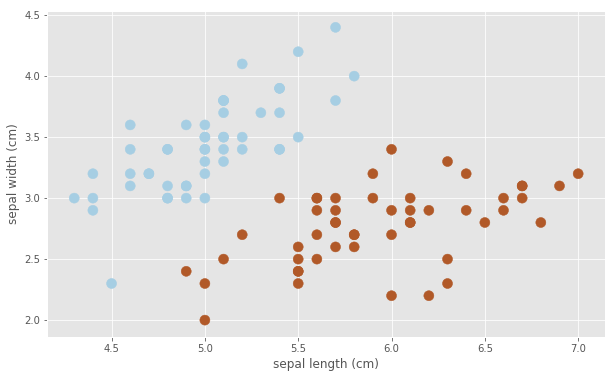

In [10]:
plt.figure(figsize=(10, 6))
plt.scatter(data[:, 0], data[:, 1], c=target, cmap=plt.cm.Paired, s=100)
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1]);

### Splitting the data into training and test sets

We learned in the previous chapter that it is essential to keep training and test data
separate. We can easily split the data using one of scikit-learn's many helper functions:

In [11]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    data, target, test_size=0.1, random_state=42
)

Here we want to split the data into 90 percent training data and 10 percent test data, which
we specify with `test_size=0.1`. By inspecting the return arguments, we note that we
ended up with exactly 90 training data points and 10 test data points:

In [12]:
X_train.shape, y_train.shape

((90, 4), (90,))

In [13]:
X_test.shape, y_test.shape

((10, 4), (10,))

### Training the classifier

Creating a logistic regression classifier involves pretty much the same steps as setting up $k$-NN:

In [14]:
lr = cv2.ml.LogisticRegression_create()

We then have to specify the desired training method. Here, we can choose
`cv2.ml.LogisticRegression_BATCH` or `cv2.ml.LogisticRegression_MINI_BATCH`.
For now, all we need to know is that we want to update the model after every data point,
which can be achieved with the following code:

In [15]:
lr.setTrainMethod(cv2.ml.LogisticRegression_MINI_BATCH)
lr.setMiniBatchSize(1)

We also want to specify the number of iterations the algorithm should run before it
terminates:

In [16]:
lr.setIterations(100)

We can then call the `train` method of the object (in the exact same way as we did earlier),
which will return `True` upon success:

In [17]:
lr.train(X_train, cv2.ml.ROW_SAMPLE, y_train);

Retrieve the learned weights:

In [18]:
lr.get_learnt_thetas()

array([[-0.04090132, -0.01910266, -0.16340332,  0.28743777,  0.11909772]],
      dtype=float32)

### Testing the classifier

Let's see for ourselves by calculating the accuracy score on the training set:

In [19]:
ret, y_pred = lr.predict(X_train)

In [20]:
metrics.accuracy_score(y_train, y_pred)

1.0

Perfect score! However, this only means that the model was able to perfectly **memorize** the
training dataset. This does not mean that the model would be able to classify a new, unseen
data point. For this, we need to check the test dataset:

In [21]:
ret, y_pred = lr.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

1.0

Luckily, we get another perfect score! Now we can be sure that the model we built is truly
awesome.

<!--NAVIGATION-->
< [Applying Lasso and Ridge Regression](03.04-Applying-Lasso-and-Ridge-Regression.ipynb) | [Contents](../README.md) | [Representing Data and Engineering Features](04.00-Representing-Data-and-Engineering-Features.ipynb) >